In [1]:
# ============================
# CELL 1: IMPORT LIBRARY
# ============================
import simpy
import random
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
import os
import warnings
warnings.filterwarnings('ignore')

print("✅ Library berhasil diimport")

✅ Library berhasil diimport


In [2]:
# ============================
# CELL 2: KONFIGURASI SIMULASI
# ============================
@dataclass
class Config:
    """Konfigurasi parameter simulasi piket kantin IT Del"""
    
    # Parameter dasar (SESUAI STUDI KASUS 2.1)
    NUM_PETUGAS: int = 7              # 7 orang mahasiswa
    NUM_MEJA: int = 60                # 60 meja
    MAHASISWA_PER_MEJA: int = 3       # 3 mahasiswa per meja
    TOTAL_OMPRENG: int = 180          # 60 x 3 = 180 ompreng
    
    # Alokasi petugas per stage
    NUM_PETUGAS_LAUK: int = 2         # Stage 1: Isi lauk
    NUM_PETUGAS_ANGKUT: int = 2       # Stage 2: Angkut ompreng
    NUM_PETUGAS_NASI: int = 3         # Stage 3: Isi nasi
    
    # Distribusi waktu (dalam menit) - SESUAI STUDI KASUS
    MIN_LAUK_TIME: float = 0.5        # 30 detik
    MAX_LAUK_TIME: float = 1.0        # 1 menit
    
    MIN_ANGKUT_TIME: float = 0.33     # 20 detik
    MAX_ANGKUT_TIME: float = 1.0      # 1 menit
    
    MIN_NASI_TIME: float = 0.5        # 30 detik
    MAX_NASI_TIME: float = 1.0        # 1 menit
    
    # Kapasitas angkut per trip - SESUAI STUDI KASUS
    MIN_OMPRENG_PER_TRIP: int = 4
    MAX_OMPRENG_PER_TRIP: int = 7
    
    # Waktu mulai - SESUAI STUDI KASUS
    START_HOUR: int = 7
    START_MINUTE: int = 0
    
    # Seed untuk reproduktibilitas
    RANDOM_SEED: int = 42

print("✅ Konfigurasi simulasi siap")
print(f"📊 Total Ompreng: {Config.TOTAL_OMPRENG}")
print(f"👥 Total Petugas: {Config.NUM_PETUGAS}")
print(f"🕐 Waktu Mulai: {Config.START_HOUR:02d}:{Config.START_MINUTE:02d}")

✅ Konfigurasi simulasi siap
📊 Total Ompreng: 180
👥 Total Petugas: 7
🕐 Waktu Mulai: 07:00


In [3]:
# ============================
# CELL 3: MODEL SIMULASI
# ============================
class PiketKantinDES:
    """Model Discrete Event Simulation untuk piket kantin IT Del"""
    
    def __init__(self, config):
        self.config = config
        self.env = simpy.Environment()
        
        # Resources: Petugas untuk 3 stage
        self.petugas_lauk = simpy.Resource(self.env, capacity=config.NUM_PETUGAS_LAUK)
        self.petugas_angkut = simpy.Resource(self.env, capacity=config.NUM_PETUGAS_ANGKUT)
        self.petugas_nasi = simpy.Resource(self.env, capacity=config.NUM_PETUGAS_NASI)
        
        # Buffer/Antrian antar stage
        self.buffer_lauk_selesai = simpy.Store(self.env)
        self.buffer_angkut_selesai = simpy.Store(self.env)
        
        # Statistik
        self.statistics = {
            'ompreng_data': [],
            'stage_times': {'lauk': [], 'angkut': [], 'nasi': []},
            'utilisasi_petugas': {'lauk': [], 'angkut': [], 'nasi': []}
        }
        
        # Waktu mulai simulasi
        self.start_time = datetime(2024, 1, 1, config.START_HOUR, config.START_MINUTE)
        
        # Set random seed
        random.seed(config.RANDOM_SEED)
        np.random.seed(config.RANDOM_SEED)
    
    def waktu_ke_jam(self, waktu_simulasi):
        """Konversi waktu simulasi (menit) ke datetime"""
        return self.start_time + timedelta(minutes=waktu_simulasi)
    
    def generate_lauk_time(self):
        """Generate waktu isi lauk (30-60 detik) dalam menit"""
        return random.uniform(self.config.MIN_LAUK_TIME, self.config.MAX_LAUK_TIME)
    
    def generate_angkut_time(self):
        """Generate waktu angkut (20-60 detik) dalam menit"""
        return random.uniform(self.config.MIN_ANGKUT_TIME, self.config.MAX_ANGKUT_TIME)
    
    def generate_nasi_time(self):
        """Generate waktu isi nasi (30-60 detik) dalam menit"""
        return random.uniform(self.config.MIN_NASI_TIME, self.config.MAX_NASI_TIME)
    
    def generate_ompreng_per_trip(self):
        """Generate jumlah ompreng per trip angkut (4-7)"""
        return random.randint(self.config.MIN_OMPRENG_PER_TRIP, self.config.MAX_OMPRENG_PER_TRIP)
    
    def proses_stage_lauk(self, ompreng_id):
        """Stage 1: Mengisi lauk ke ompreng"""
        with self.petugas_lauk.request() as request:
            yield request
            
            # Catat utilisasi
            self.statistics['utilisasi_petugas']['lauk'].append({
                'time': self.env.now,
                'in_use': self.petugas_lauk.count
            })
            
            # Proses isi lauk
            lauk_time = self.generate_lauk_time()
            yield self.env.timeout(lauk_time)
        
        # Simpan ke buffer stage berikutnya
        yield self.buffer_lauk_selesai.put({
            'ompreng_id': ompreng_id,
            'waktu_lauk': lauk_time
        })
        
        self.statistics['stage_times']['lauk'].append(lauk_time)
    
    def proses_stage_angkut(self):
        """Stage 2: Mengangkat ompreng ke meja (batch processing)"""
        ompreng_batch = []
        trip_count = 0
        ompreng_selesai_lauk = 0
        
        while ompreng_selesai_lauk < self.config.TOTAL_OMPRENG or len(ompreng_batch) > 0:
            # Tunggu ada item di buffer
            if len(self.buffer_lauk_selesai.items) > 0:
                item = yield self.buffer_lauk_selesai.get()
                ompreng_batch.append(item)
                ompreng_selesai_lauk += 1
            else:
                # Tunggu sebentar jika buffer kosong
                yield self.env.timeout(0.01)
                continue
            
            # Cek apakah sudah cukup untuk satu trip
            ompreng_per_trip = self.generate_ompreng_per_trip()
            
            if len(ompreng_batch) >= ompreng_per_trip or ompreng_selesai_lauk >= self.config.TOTAL_OMPRENG:
                trip_count += 1
                
                # Proses angkut batch ini
                with self.petugas_angkut.request() as request:
                    yield request
                    
                    # Catat utilisasi
                    self.statistics['utilisasi_petugas']['angkut'].append({
                        'time': self.env.now,
                        'in_use': self.petugas_angkut.count,
                        'batch_size': len(ompreng_batch),
                        'trip': trip_count
                    })
                    
                    # Proses angkut
                    angkut_time = self.generate_angkut_time()
                    yield self.env.timeout(angkut_time)
                
                # Kirim ke buffer stage berikutnya
                for item in ompreng_batch:
                    yield self.buffer_angkut_selesai.put({
                        'ompreng_id': item['ompreng_id'],
                        'waktu_angkut': angkut_time / len(ompreng_batch),
                        'waktu_lauk': item['waktu_lauk']
                    })
                
                self.statistics['stage_times']['angkut'].append(angkut_time)
                ompreng_batch = []
    
    def proses_stage_nasi(self, ompreng_id, data_sebelumnya):
        """Stage 3: Menambahkan nasi ke ompreng"""
        with self.petugas_nasi.request() as request:
            yield request
            
            # Catat utilisasi
            self.statistics['utilisasi_petugas']['nasi'].append({
                'time': self.env.now,
                'in_use': self.petugas_nasi.count
            })
            
            # Proses isi nasi
            nasi_time = self.generate_nasi_time()
            yield self.env.timeout(nasi_time)
        
        # Simpan data lengkap ompreng
        self.statistics['ompreng_data'].append({
            'id': ompreng_id,
            'waktu_lauk': data_sebelumnya['waktu_lauk'],
            'waktu_angkut': data_sebelumnya['waktu_angkut'],
            'waktu_nasi': nasi_time,
            'total_waktu': data_sebelumnya['waktu_lauk'] + data_sebelumnya['waktu_angkut'] + nasi_time,
            'waktu_selesai': self.env.now,
            'jam_selesai': self.waktu_ke_jam(self.env.now)
        })
        
        self.statistics['stage_times']['nasi'].append(nasi_time)
    
    def proses_kedatangan_ompreng(self):
        """Generate proses untuk semua ompreng"""
        # Start stage 1 untuk semua ompreng
        for i in range(self.config.TOTAL_OMPRENG):
            self.env.process(self.proses_stage_lauk(i))
        
        # Start stage 2 (batch processing)
        self.env.process(self.proses_stage_angkut())
        
        # Start stage 3 - tunggu sampai ada data di buffer angkut
        ompreng_diproses = 0
        while ompreng_diproses < self.config.TOTAL_OMPRENG:
            if len(self.buffer_angkut_selesai.items) > 0:
                data = yield self.buffer_angkut_selesai.get()
                self.env.process(self.proses_stage_nasi(data['ompreng_id'], data))
                ompreng_diproses += 1
            else:
                yield self.env.timeout(0.01)
    
    def run_simulation(self):
        """Jalankan simulasi"""
        self.env.process(self.proses_kedatangan_ompreng())
        self.env.run()
        return self.analyze_results()
    
    def analyze_results(self):
        """Analisis hasil simulasi"""
        if not self.statistics['ompreng_data']:
            return None, None
        
        df = pd.DataFrame(self.statistics['ompreng_data'])
        
        results = {
            'total_ompreng': len(df),
            'waktu_selesai_terakhir': df['waktu_selesai'].max(),
            'jam_selesai_terakhir': self.waktu_ke_jam(df['waktu_selesai'].max()),
            'durasi_total_menit': df['waktu_selesai'].max(),
            'avg_lauk_time': np.mean(self.statistics['stage_times']['lauk']),
            'avg_angkut_time': np.mean(self.statistics['stage_times']['angkut']),
            'avg_nasi_time': np.mean(self.statistics['stage_times']['nasi']),
            'total_lauk_time': sum(self.statistics['stage_times']['lauk']),
            'total_angkut_time': sum(self.statistics['stage_times']['angkut']),
            'total_nasi_time': sum(self.statistics['stage_times']['nasi']),
            'utilisasi_petugas': self.calculate_utilization(df),
            'total_trip_angkut': len(self.statistics['stage_times']['angkut'])
        }
        
        return results, df
    
    def calculate_utilization(self, df):
        """Hitung utilisasi petugas per stage"""
        total_time = df['waktu_selesai'].max()
        utilization = {}
        
        if self.statistics['stage_times']['lauk']:
            total_lauk = sum(self.statistics['stage_times']['lauk'])
            utilization['lauk'] = (total_lauk / (total_time * self.config.NUM_PETUGAS_LAUK)) * 100
        
        if self.statistics['stage_times']['angkut']:
            total_angkut = sum(self.statistics['stage_times']['angkut'])
            utilization['angkut'] = (total_angkut / (total_time * self.config.NUM_PETUGAS_ANGKUT)) * 100
        
        if self.statistics['stage_times']['nasi']:
            total_nasi = sum(self.statistics['stage_times']['nasi'])
            utilization['nasi'] = (total_nasi / (total_time * self.config.NUM_PETUGAS_NASI)) * 100
        
        return utilization

print("✅ Model PiketKantinDES siap")

✅ Model PiketKantinDES siap


In [4]:
# ============================
# CELL 4: JALANKAN SIMULASI
# ============================
print("="*70)
print("SIMULASI PIKET KANTIN IT DEL - STUDI KASUS 2.1")
print("="*70)

# Buat konfigurasi
config = Config()

# Buat dan jalankan model
print("\n⏳ Menjalankan simulasi...")
model = PiketKantinDES(config)
results, df = model.run_simulation()

# Tampilkan hasil
if results:
    print("\n" + "="*70)
    print("📊 HASIL SIMULASI")
    print("="*70)
    print(f"Total Ompreng: {results['total_ompreng']}")
    print(f"Jam Mulai: {model.start_time.strftime('%H:%M')}")
    print(f"Jam Selesai Terakhir: {results['jam_selesai_terakhir'].strftime('%H:%M')}")
    print(f"Durasi Total: {results['durasi_total_menit']:.2f} menit")
    
    print(f"\n⏱️ Waktu Rata-rata per Stage:")
    print(f"  Stage 1 (Lauk): {results['avg_lauk_time']:.2f} menit")
    print(f"  Stage 2 (Angkut): {results['avg_angkut_time']:.2f} menit")
    print(f"  Stage 3 (Nasi): {results['avg_nasi_time']:.2f} menit")
    
    print(f"\n👥 Utilisasi Petugas:")
    for stage, util in results['utilisasi_petugas'].items():
        stage_name = {'lauk': 'Stage 1 (Lauk)', 'angkut': 'Stage 2 (Angkut)', 'nasi': 'Stage 3 (Nasi)'}
        print(f"  {stage_name[stage]}: {util:.1f}%")
    
    print(f"\n🚚 Total Trip Angkut: {results['total_trip_angkut']}")
    print("="*70)
else:
    print("❌ Simulasi gagal!")

SIMULASI PIKET KANTIN IT DEL - STUDI KASUS 2.1

⏳ Menjalankan simulasi...

📊 HASIL SIMULASI
Total Ompreng: 180
Jam Mulai: 07:00
Jam Selesai Terakhir: 08:09
Durasi Total: 69.59 menit

⏱️ Waktu Rata-rata per Stage:
  Stage 1 (Lauk): 0.74 menit
  Stage 2 (Angkut): 0.69 menit
  Stage 3 (Nasi): 0.76 menit

👥 Utilisasi Petugas:
  Stage 1 (Lauk): 95.7%
  Stage 2 (Angkut): 17.5%
  Stage 3 (Nasi): 65.1%

🚚 Total Trip Angkut: 35


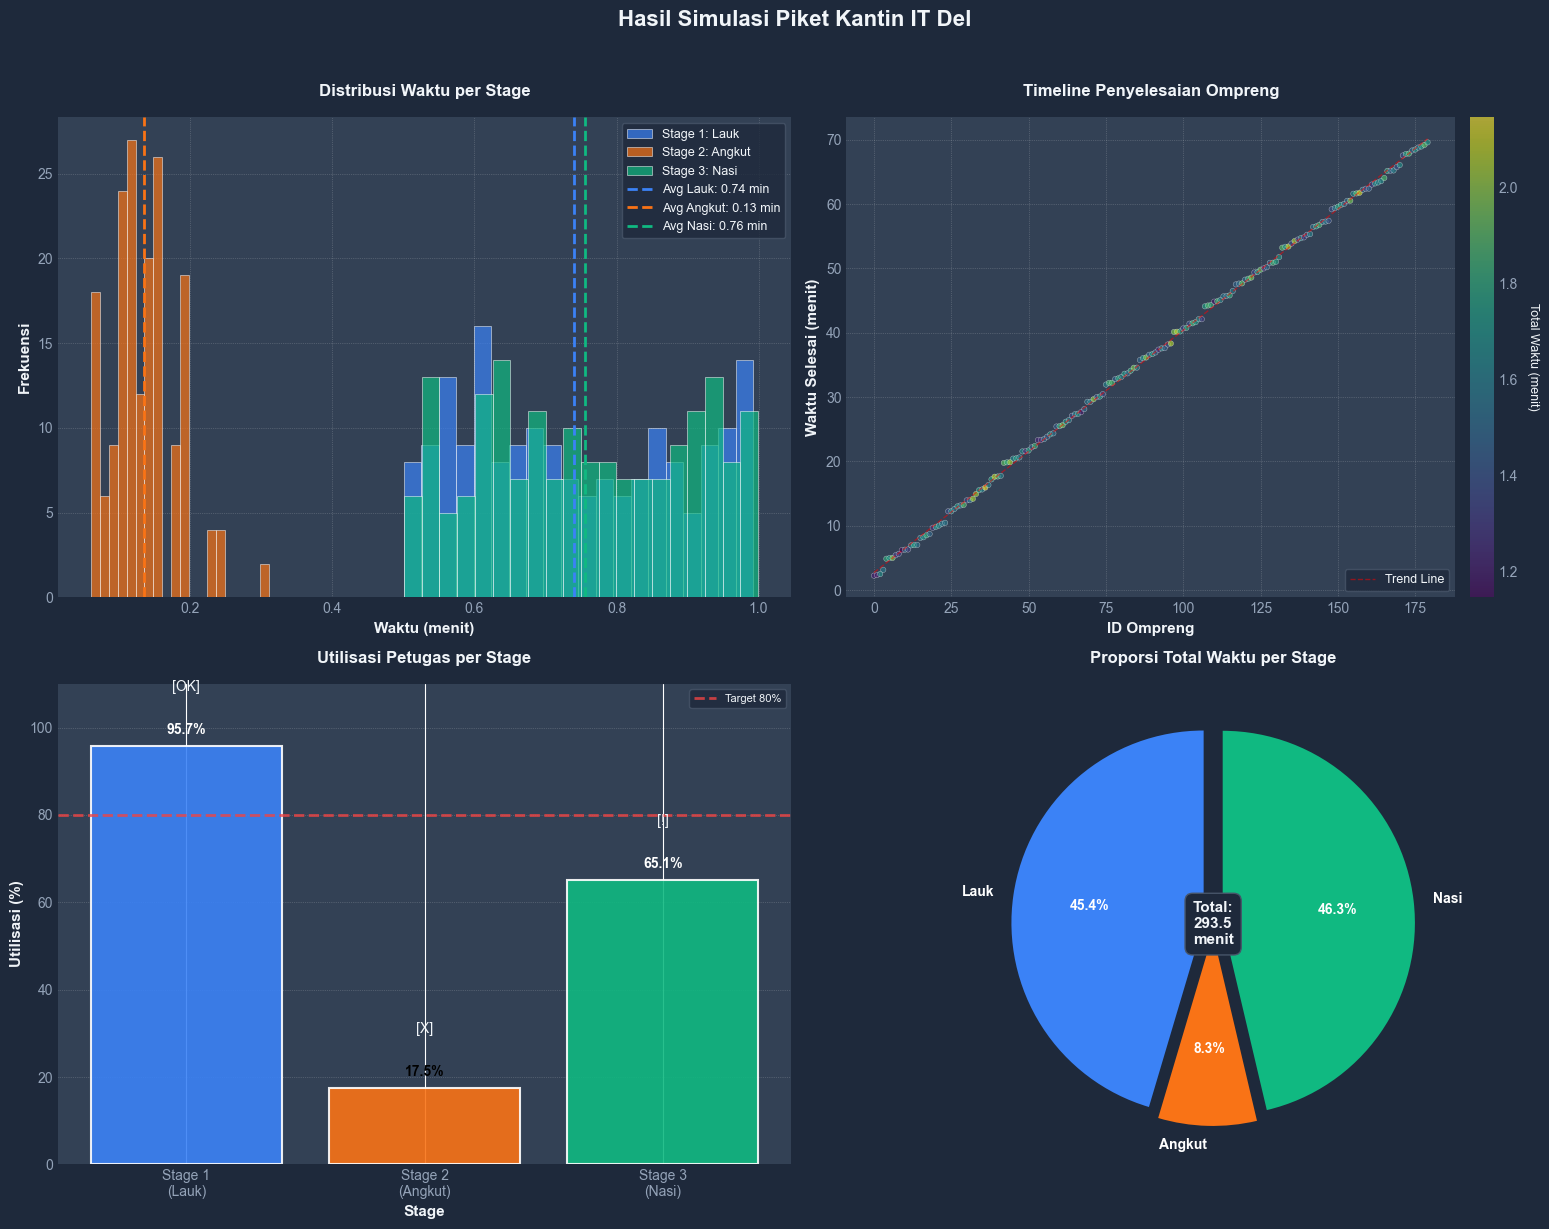


VISUALISASI BERHASIL DIBUAT!
File tersimpan di: artifacts/
  - visualisasi_piket.png (300 DPI)
  - visualisasi_piket.pdf (Vector)


In [5]:
# ============================
# CELL 5: VISUALISASI HASIL
# ============================

# Buat folder artifacts jika belum ada
os.makedirs('artifacts', exist_ok=True)

# Set style matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = '#1E293B'
plt.rcParams['axes.facecolor'] = '#334155'
plt.rcParams['axes.edgecolor'] = '#475569'
plt.rcParams['axes.labelcolor'] = '#F1F5F9'
plt.rcParams['xtick.color'] = '#94A3B8'
plt.rcParams['ytick.color'] = '#94A3B8'
plt.rcParams['text.color'] = '#F1F5F9'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11

# Buat figure dengan 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hasil Simulasi Piket Kantin IT Del', 
             fontsize=16, fontweight='bold', color='#F1F5F9', y=1.02)

# Warna untuk setiap stage
colors = {
    'lauk': '#3B82F6',      # Biru
    'angkut': '#F97316',    # Orange
    'nasi': '#10B981'       # Hijau
}

# =============================================================================
# CHART 1: Distribusi Waktu per Stage (Top-Left)
# =============================================================================
ax = axes[0, 0]

ax.hist(df['waktu_lauk'], bins=20, alpha=0.7, label='Stage 1: Lauk', 
        edgecolor='white', linewidth=0.5, color=colors['lauk'])
ax.hist(df['waktu_angkut'], bins=20, alpha=0.7, label='Stage 2: Angkut', 
        edgecolor='white', linewidth=0.5, color=colors['angkut'])
ax.hist(df['waktu_nasi'], bins=20, alpha=0.7, label='Stage 3: Nasi', 
        edgecolor='white', linewidth=0.5, color=colors['nasi'])

avg_lauk = df['waktu_lauk'].mean()
avg_angkut = df['waktu_angkut'].mean()
avg_nasi = df['waktu_nasi'].mean()

ax.axvline(avg_lauk, color=colors['lauk'], linestyle='--', linewidth=2, 
           label=f'Avg Lauk: {avg_lauk:.2f} min')
ax.axvline(avg_angkut, color=colors['angkut'], linestyle='--', linewidth=2,
           label=f'Avg Angkut: {avg_angkut:.2f} min')
ax.axvline(avg_nasi, color=colors['nasi'], linestyle='--', linewidth=2,
           label=f'Avg Nasi: {avg_nasi:.2f} min')

ax.set_xlabel('Waktu (menit)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frekuensi', fontsize=11, fontweight='bold')
ax.set_title('Distribusi Waktu per Stage', fontsize=12, fontweight='bold', pad=15)
ax.legend(fontsize=9, loc='upper right', frameon=True, facecolor='#1E293B', edgecolor='#475569')
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

# =============================================================================
# CHART 2: Timeline Penyelesaian Ompreng (Top-Right)
# =============================================================================
ax = axes[0, 1]

scatter = ax.scatter(df.index, df['waktu_selesai'], 
                     c=df['total_waktu'], 
                     cmap='viridis', 
                     s=15, 
                     alpha=0.6,
                     edgecolors='white',
                     linewidth=0.3)

z = np.polyfit(df.index, df['waktu_selesai'], 1)
p = np.poly1d(z)
ax.plot(df.index, p(df.index), "r--", alpha=0.5, linewidth=1, label='Trend Line')

cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Total Waktu (menit)', fontsize=9, rotation=270, labelpad=15)

ax.set_xlabel('ID Ompreng', fontsize=11, fontweight='bold')
ax.set_ylabel('Waktu Selesai (menit)', fontsize=11, fontweight='bold')
ax.set_title('Timeline Penyelesaian Ompreng', fontsize=12, fontweight='bold', pad=15)
ax.legend(fontsize=9, loc='lower right', frameon=True, facecolor='#1E293B', edgecolor='#475569')
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

# =============================================================================
# CHART 3: Utilisasi Petugas per Stage (Bottom-Left)
# =============================================================================
ax = axes[1, 0]

stages = list(results['utilisasi_petugas'].keys())
utils = list(results['utilisasi_petugas'].values())
stage_labels = ['Stage 1\n(Lauk)', 'Stage 2\n(Angkut)', 'Stage 3\n(Nasi)']

bars = ax.bar(stage_labels, utils, 
              color=[colors['lauk'], colors['angkut'], colors['nasi']],
              edgecolor='white', linewidth=1.5, alpha=0.9)

for bar, util in zip(bars, utils):
    height = bar.get_height()
    text_color = 'white' if util > 50 else 'black'
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{util:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color=text_color)
    
    # Gunakan text biasa bukan emoji untuk menghindari warning
    if util >= 80:
        status = '[OK]'
    elif util >= 60:
        status = '[!]'
    else:
        status = '[X]'
    ax.text(bar.get_x() + bar.get_width()/2., height + 12,
            status, ha='center', va='bottom', fontsize=10)

ax.axhline(y=80, color='#EF4444', linestyle='--', linewidth=2, 
           label='Target 80%', alpha=0.8)

ax.set_xlabel('Stage', fontsize=11, fontweight='bold')
ax.set_ylabel('Utilisasi (%)', fontsize=11, fontweight='bold')
ax.set_title('Utilisasi Petugas per Stage', fontsize=12, fontweight='bold', pad=15)
ax.set_ylim(0, 110)
ax.legend(fontsize=8, loc='upper right', frameon=True, facecolor='#1E293B', edgecolor='#475569')
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5, axis='y')

# =============================================================================
# CHART 4: Proporsi Total Waktu per Stage (Bottom-Right)
# =============================================================================
ax = axes[1, 1]

total_times = [results['total_lauk_time'], results['total_angkut_time'], results['total_nasi_time']]
stage_names_simple = ['Lauk', 'Angkut', 'Nasi']

wedges, texts, autotexts = ax.pie(total_times, 
                                   labels=stage_names_simple,
                                   autopct='%1.1f%%',
                                   colors=[colors['lauk'], colors['angkut'], colors['nasi']],
                                   startangle=90,
                                   explode=(0.05, 0.05, 0.05),
                                   textprops={'fontsize': 10, 'color': 'white', 'weight': 'bold'})

ax.text(0, 0, f'Total:\n{sum(total_times):.1f}\nmenit', 
        ha='center', va='center', fontsize=11, fontweight='bold', 
        bbox=dict(boxstyle='round', facecolor='#1E293B', edgecolor='#475569', pad=0.5))

ax.set_title('Proporsi Total Waktu per Stage', fontsize=12, fontweight='bold', pad=15)

# =============================================================================
# FINAL TOUCHES
# =============================================================================
plt.tight_layout()

# Simpan dengan quality tinggi
plt.savefig('artifacts/visualisasi_piket.png', dpi=300, bbox_inches='tight', facecolor='#0E1117')
plt.savefig('artifacts/visualisasi_piket.pdf', bbox_inches='tight', facecolor='#0E1117')

# Tampilkan
plt.show()

# Print summary
print("\n" + "="*70)
print("VISUALISASI BERHASIL DIBUAT!")
print("="*70)
print(f"File tersimpan di: artifacts/")
print(f"  - visualisasi_piket.png (300 DPI)")
print(f"  - visualisasi_piket.pdf (Vector)")
print("="*70)

In [6]:
# ============================
# CELL 6: ANALISIS HASIL
# ============================
print("\n" + "="*70)
print("ANALISIS HASIL SIMULASI")
print("="*70)

# Hitung utilisasi rata-rata
avg_util = np.mean(list(results['utilisasi_petugas'].values()))

# Cari stage dengan utilisasi tertinggi
max_util_stage = max(results['utilisasi_petugas'], key=results['utilisasi_petugas'].get)
max_util_value = results['utilisasi_petugas'][max_util_stage]

print(f"\n📈 Utilisasi Rata-rata: {avg_util:.1f}%")

# Analisis utilisasi
if avg_util > 80:
    print("⚠️  Utilisasi tinggi! Pertimbangkan menambah petugas.")
elif avg_util < 50:
    print("ℹ️  Utilisasi rendah. Sistem memiliki kapasitas berlebih.")
else:
    print("✅ Utilisasi optimal. Sistem berjalan dengan baik.")

# Nama stage
stage_names = {
    'lauk': 'Stage 1 (Lauk)', 
    'angkut': 'Stage 2 (Angkut)', 
    'nasi': 'Stage 3 (Nasi)'
}

print(f"\n🎯 Stage dengan utilisasi tertinggi: {stage_names[max_util_stage]} ({max_util_value:.1f}%)")
print(f"💡 Rekomendasi: Fokus optimasi pada {stage_names[max_util_stage]} untuk meningkatkan kinerja sistem.")

print(f"\n⏰ Waktu Penyelesaian:")
print(f"  Mulai: {model.start_time.strftime('%H:%M')}")
print(f"  Selesai: {results['jam_selesai_terakhir'].strftime('%H:%M')}")
print(f"  Durasi: {results['durasi_total_menit']:.2f} menit")

print(f"\n📊 Ringkasan:")
print(f"  Total Ompreng: {results['total_ompreng']}")
print(f"  Total Trip Angkut: {results['total_trip_angkut']}")
print(f"  Rata-rata Waktu Lauk: {results['avg_lauk_time']:.2f} menit")
print(f"  Rata-rata Waktu Angkut: {results['avg_angkut_time']:.2f} menit")
print(f"  Rata-rata Waktu Nasi: {results['avg_nasi_time']:.2f} menit")

print("\n" + "="*70)
print("SIMULASI SELESAI")
print("="*70)


ANALISIS HASIL SIMULASI

📈 Utilisasi Rata-rata: 59.4%
✅ Utilisasi optimal. Sistem berjalan dengan baik.

🎯 Stage dengan utilisasi tertinggi: Stage 1 (Lauk) (95.7%)
💡 Rekomendasi: Fokus optimasi pada Stage 1 (Lauk) untuk meningkatkan kinerja sistem.

⏰ Waktu Penyelesaian:
  Mulai: 07:00
  Selesai: 08:09
  Durasi: 69.59 menit

📊 Ringkasan:
  Total Ompreng: 180
  Total Trip Angkut: 35
  Rata-rata Waktu Lauk: 0.74 menit
  Rata-rata Waktu Angkut: 0.69 menit
  Rata-rata Waktu Nasi: 0.76 menit

SIMULASI SELESAI
